# É uma ferramenta para ser utilizada em momentos de depressão ou euforia!

# Relação Sinal-Ruído (SNR)

- A Relação Sinal-Ruído (SNR) é uma métrica que compara o nível do sinal desejado ao nível do ruído presente no sinal
- A SNR é geralmente expressa em decibéis (dB)
- Uma SNR alta indica que o nível do sinal é significativamente maior que o nível do ruído.

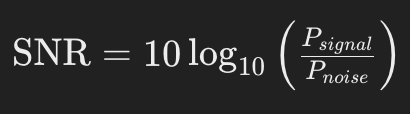

# Exemplo de aplicação

In [60]:
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Função para calcular o SNR

def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((signal - np.mean(signal)) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Função para calcular o SNR com uma janela móvel
def rolling_snr(signal, window):
    snr_values = []
    for i in range(len(signal) - window + 1):
        window_signal = signal[i:i+window]
        snr = calculate_snr(window_signal)
        snr_values.append(snr)
    # Preenchendo com NaNs para alinhar os índices
    return np.concatenate((np.full(window - 1, np.nan), np.array(snr_values)))

# Função para plotar o SNR e o Adj Close
def plot_snr_adj_close(ticker, dates, adj_close, snr_values, window):
    fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, vertical_spacing = 0.1, subplot_titles = ("Adj Close", "SNR"))
    
    fig.add_trace(go.Scatter(x = dates, y = adj_close, mode = "lines", name = "Adj Close", line = dict(color = "blue")), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = dates, y = snr_values, mode = "lines", name = "SNR", line = dict(color = "red")), row = 2, col = 1)
    
    fig.update_layout(
        title=ticker + " - Adj Close e Rolling SNR (" + str(window) + " dias)",
        height=900,
        width=900
    )
    
    fig.update_xaxes(title_text = "Data", row = 2, col = 1)
    fig.update_yaxes(title_text = "Adj Close", row = 1, col = 1)
    fig.update_yaxes(title_text = "SNR (dB)", row = 2, col = 1)
    
    fig.show()

# Função para plotar o scatter plot entre SNR e Returns
def plot_snr_vs_returns(dates, snr_values, returns):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x = snr_values, y = returns, mode = "markers", name = "SNR vs Returns", marker = dict(color = "green")))
    
    fig.update_layout(
        title = "Scatter Plot: SNR vs STD",
        height = 600,
        width = 900,
        xaxis_title = "SNR (dB)",
        yaxis_title = "STD"
    )
    
    fig.show()

# Baixar dados
ticker = "CMIG4.SA"
df = yf.download(ticker, start = "2015-01-01", end = "2025-01-01", progress = False)
df["Returns"] = df["Adj Close"].pct_change(1)
df["STD"] = df["Returns"].rolling(20).std()


# Preparar o sinal (usaremos os preços de fechamento ajustados)
signal = df["Adj Close"].values
dates = df.index

# Calcular o rolling SNR com uma janela de 20 dias
window = 20
snr_values = rolling_snr(signal, window)

# Adicionar os valores do SNR ao dataframe
df["SNR"] = snr_values



# Plotar o rolling SNR e o STD
plot_snr_adj_close(ticker, dates, df["Adj Close"], df["SNR"], window)

# Plotar o scatter plot entre SNR e STD
plot_snr_vs_returns(dates, df["SNR"], df["STD"])


# Trading com a SNR

In [66]:

# Função para criar sinais de compra e venda baseados no SNR
def create_trading_signals(df, window):
    df["SNR"] = rolling_snr(df["Adj Close"].values, window)
    df["Signal"] = 0  # 0: hold, 1: buy, -1: sell

    # Regras de trading: comprar quando SNR < threshold, vender quando SNR > threshold
    threshold_buy = df["SNR"].min()*1.5
    threshold_sell = df["SNR"].max()*0.9

    df.loc[df["SNR"].rolling(10).mean() < threshold_buy, "Signal"] = 1
    df.loc[df["SNR"].rolling(10).mean() > threshold_sell, "Signal"] = -1

    return df

# Baixar dados 
ticker = "BOVA11.SA"
df = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)

# Calcular o rolling SNR com uma janela de X dias
window = 20
df = create_trading_signals(df, window)

# Plotar os dados e sinais de trading
fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, vertical_spacing = 0.1, subplot_titles = ("Adj Close", "SNR"))

# Plot Adj Close
fig.add_trace(go.Scatter(x = df.index, y = df["Adj Close"], mode = "lines", name = "Adj Close", line = dict(color = "blue"))
              , row = 1, col = 1)

# Plot SNR
fig.add_trace(go.Scatter(x = df.index, y = df["SNR"], mode = "lines", name = "SNR", line = dict(color = "red"))
              , row = 2, col = 1)

# Adicionar sinais de compra e venda no gráfico de Adj Close
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]

fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals["Adj Close"], mode="markers", name="Buy Signal", marker=dict(color="green", size=10, symbol="triangle-up")), row=1, col=1)
fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals["Adj Close"], mode="markers", name="Sell Signal", marker=dict(color="red", size=10, symbol="triangle-down")), row=1, col=1)

# Configurações do layout
fig.update_layout(
    title=ticker + " - Adj Close e SNR com Sinais de Trading",
    height=800,
    width=800
)

fig.update_xaxes(title_text = "Data", row = 2, col = 1)
fig.update_yaxes(title_text = "Adj Close", row = 1, col = 1)
fig.update_yaxes(title_text = "SNR (dB)", row = 2, col = 1)

fig.show()
